In [1]:
import gradcam
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

import pandaGenerator

config= gradcam.config(seed = 2023,
            model_name="seresnext50",
            batch_size = 4,
            img_size = 64,
            num_tiles = 16,
            num_classes = 6,
            num_splits = 5,
            num_epochs = 5,
            learning_rate = 3e-3,
            num_workers = 1,
            verbose = True,
            train_data_name="64_4_4_0",
            last_conv_layer_name = 'activation_80',
            classifier_layer_names = [
                'global_average_pooling2d_16',
                'dense'
                ]
            )

gradcam.seed_everything(config.seed)



df = pd.read_csv(config.train_csv)
df = df.sample(frac=1, random_state=config.seed).reset_index(drop=True)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=config.seed)



In [2]:
train_datagen = pandaGenerator.PANDAGenerator(
    df=train_df, 
    config=config,
    mode='fit', 
    apply_tfms=False,
    shuffle=True, 
)

val_datagen = pandaGenerator.PANDAGenerator(
    df=valid_df, 
    config=config,
    mode='fit', 
    apply_tfms=False,
    shuffle=False, 
)

Shape of X:  (4, 256, 256, 3)
Shape of y:  (4, 6)


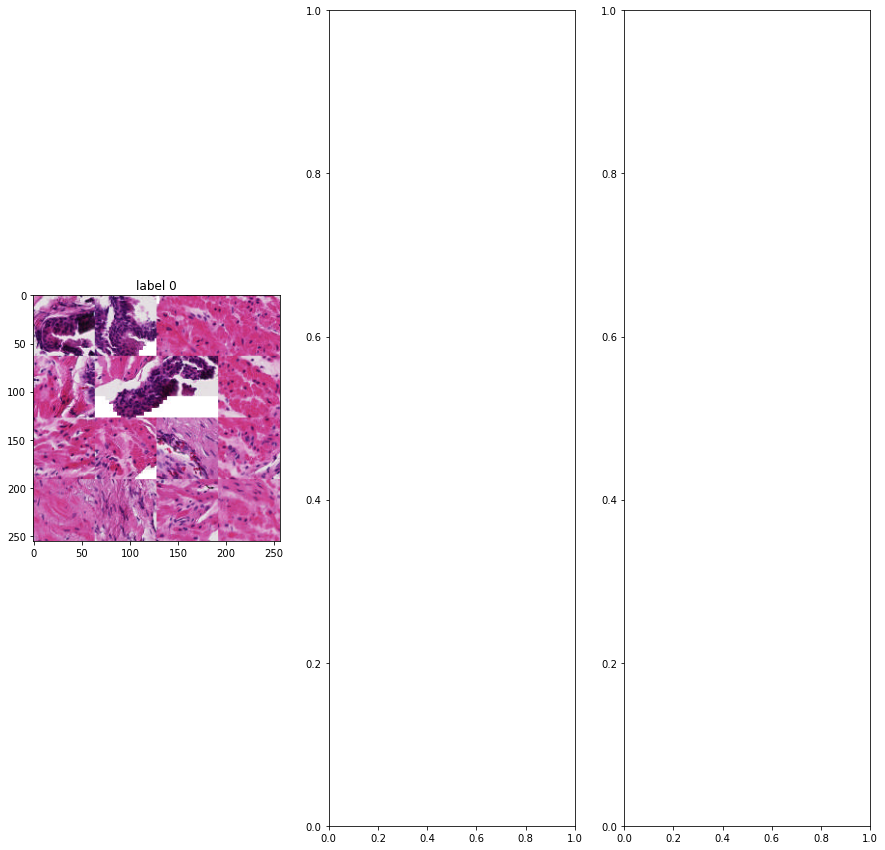

In [3]:
import matplotlib.pyplot as plt
import numpy as np

Xt, yt = train_datagen.__getitem__(0)

print('Shape of X: ', Xt.shape)
print('Shape of y: ', yt.shape)

fig, ax = plt.subplots(figsize=(15, 15), ncols=3)

for i in range(1):
    ax[i].imshow(Xt[i])
    ax[i].set_title('label {}'.format(np.argmax(yt[i, ])))
plt.show()



In [4]:
import models

model = models.factory(config)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

cb1 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=1, min_lr=1e-6)
cb2 = ModelCheckpoint("modelcheckpoints/{}/{}.h5".format(config.train_data_name,config.model_name), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')



In [6]:


history = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    callbacks=[cb1, cb2],
    epochs=config.num_epochs,
    verbose=1
)



Epoch 1/5
121/121 [==============================] - ETA: 0s - loss: 2.1221 - cohen_kappa: 0.0527
Epoch 1: val_loss improved from inf to 4696.39844, saving model to modelcheckpoints/64_4_4_0\seresnext50.h5
121/121 [==============================] - 70s 354ms/step - loss: 2.1221 - cohen_kappa: 0.0527 - val_loss: 4696.3984 - val_cohen_kappa: 0.0000e+00 - lr: 0.0030
Epoch 2/5
121/121 [==============================] - ETA: 0s - loss: 1.8513 - cohen_kappa: 0.0444
Epoch 2: val_loss improved from 4696.39844 to 2.98043, saving model to modelcheckpoints/64_4_4_0\seresnext50.h5
121/121 [==============================] - 39s 321ms/step - loss: 1.8513 - cohen_kappa: 0.0444 - val_loss: 2.9804 - val_cohen_kappa: 0.1329 - lr: 0.0030
Epoch 3/5
121/121 [==============================] - ETA: 0s - loss: 1.8265 - cohen_kappa: 0.0453
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.

Epoch 3: val_loss did not improve from 2.98043
121/121 [==============================] - 38s 31

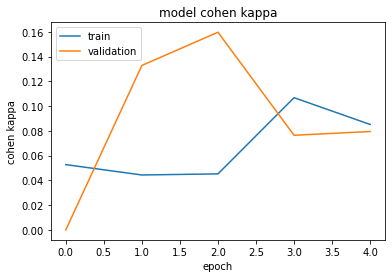

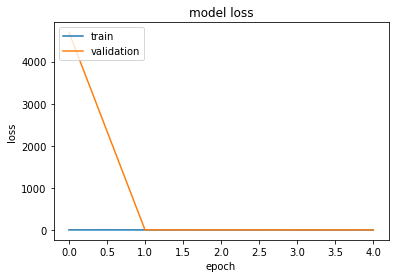

In [7]:
#  "Accuracy"
plt.plot(history.history['cohen_kappa'])
plt.plot(history.history['val_cohen_kappa'])
plt.title('model cohen kappa')
plt.ylabel('cohen kappa')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
import tensorflow as tf
model=tf.keras.models.load_model("modelcheckpoints/{}/{}.h5".format(config.train_data_name,config.model_name))



tf.Tensor([[0.16960618 0.18130803 0.16196735 0.15586865 0.17015705 0.16109277]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[0.17183694 0.17921196 0.162614   0.15670955 0.16474661 0.16488096]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[0.14883459 0.18595505 0.17238542 0.18508114 0.16822964 0.13951418]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[0.16618226 0.18471752 0.16354695 0.1576584  0.17051314 0.1573817 ]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


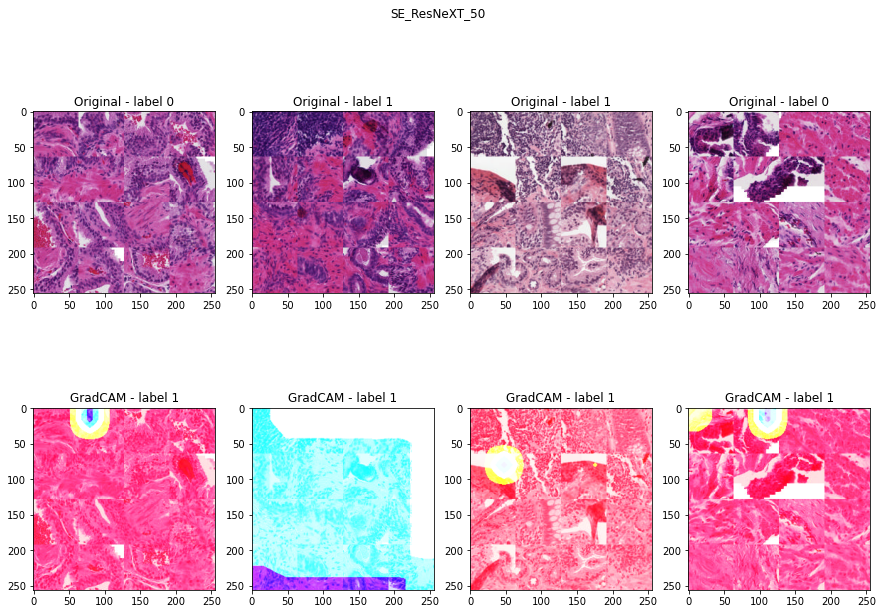

In [10]:
import matplotlib.pyplot as plt
import cv2
from numpy import random
fig, ax = plt.subplots(figsize=(15, 10), ncols=4, nrows=2)


for i in range(4):
    raw_image, y = train_datagen.__getitem__(random.randint(10))
    image = np.expand_dims(raw_image[0], axis=0)
    heatmap,prediction = gradcam.make_gradcam_heatmap(image, model, config.last_conv_layer_name, config.classifier_layer_names)
    superimposed_image = gradcam.create_superimposed_visualization(raw_image[0], heatmap,cv2.COLORMAP_JET)

    ax[0][i].imshow(raw_image[0])
    ax[0][i].set_title('Original - label {}'.format(np.argmax(y[0])))
    ax[1][i].imshow(superimposed_image)
    ax[1][i].set_title('GradCAM - label {}'.format(prediction))

fig.suptitle('SE_ResNeXT_50')
plt.show()